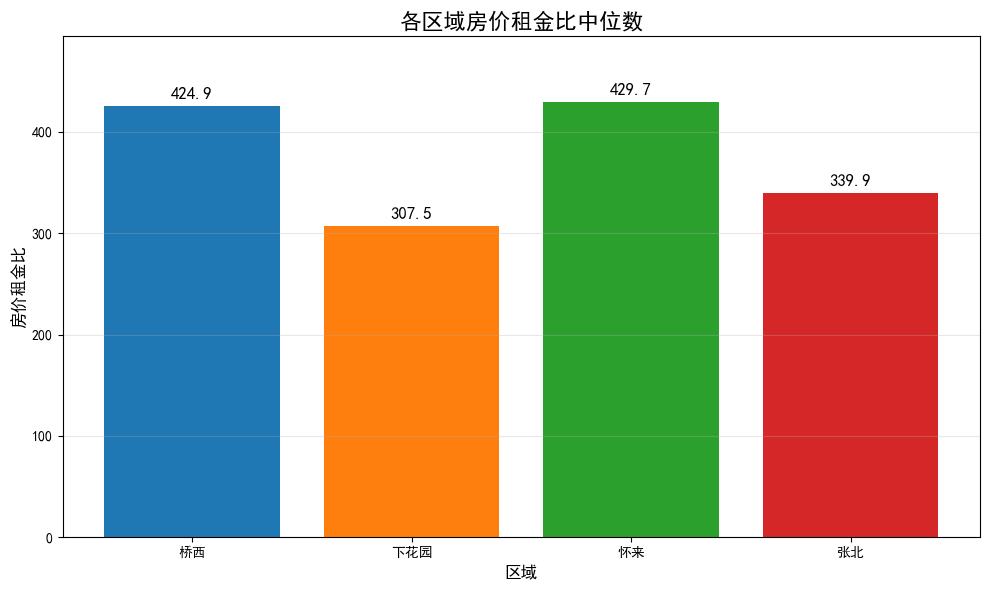

各区域租售比中位数:
桥西: 424.92
下花园: 307.49
怀来: 429.71
张北: 339.94


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
zu_df = pd.read_excel('combined_zu_data.xlsx')
esf_df = pd.read_excel('combined_esf_data.xlsx')

# 计算每平米租金
zu_df['rent_per_m2'] = zu_df['租金'] / zu_df['面积']

# 训练模型 - 使用三个地区变量，以怀来为基准组
X_price = esf_df[['面积', '桥西', '下花园', '张北']]
y_price = esf_df['单价']
model_price = LinearRegression().fit(X_price, y_price)

X_rent = zu_df[['面积', '桥西', '下花园', '张北']]
y_rent = zu_df['rent_per_m2']
model_rent = LinearRegression().fit(X_rent, y_rent)

# 合并数据并预测
all_data = pd.concat([
    zu_df[['面积', '桥西', '下花园', '怀来', '张北']],  # 保留怀来用于区域标签
    esf_df[['面积', '桥西', '下花园', '怀来', '张北']]
], ignore_index=True).drop_duplicates()

# 预测时使用三个地区变量
all_data['predicted_price'] = model_price.predict(all_data[['面积', '桥西', '下花园', '张北']])
all_data['predicted_rent'] = model_rent.predict(all_data[['面积', '桥西', '下花园', '张北']])
all_data['price_to_rent_ratio'] = all_data['predicted_price'] / all_data['predicted_rent']

# 添加区域标签
conditions = [
    all_data['桥西'] == 1,
    all_data['下花园'] == 1, 
    all_data['张北'] == 1,
    all_data['怀来'] == 1  # 怀来作为基准组
]
choices = ['桥西', '下花园', '张北', '怀来']
all_data['region'] = np.select(conditions, choices, default='未知')

# 计算中位数并按指定顺序排序
desired_order = ['桥西', '下花园', '怀来', '张北']
median_ratios = all_data.groupby('region')['price_to_rent_ratio'].median()
median_ratios = median_ratios.reindex(desired_order)

# 绘制条形图
plt.figure(figsize=(10, 6))
bars = plt.bar(median_ratios.index, median_ratios.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for bar, value in zip(bars, median_ratios.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', 
             ha='center', va='bottom', fontsize=12)

plt.title('各区域房价租金比中位数', fontsize=16, fontweight='bold')
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价租金比', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(median_ratios.values) * 1.15)
plt.tight_layout()
plt.show()

# 输出结果
print("各区域房价租金比中位数:")
for region, ratio in median_ratios.items():
    print(f"{region}: {ratio:.2f}")

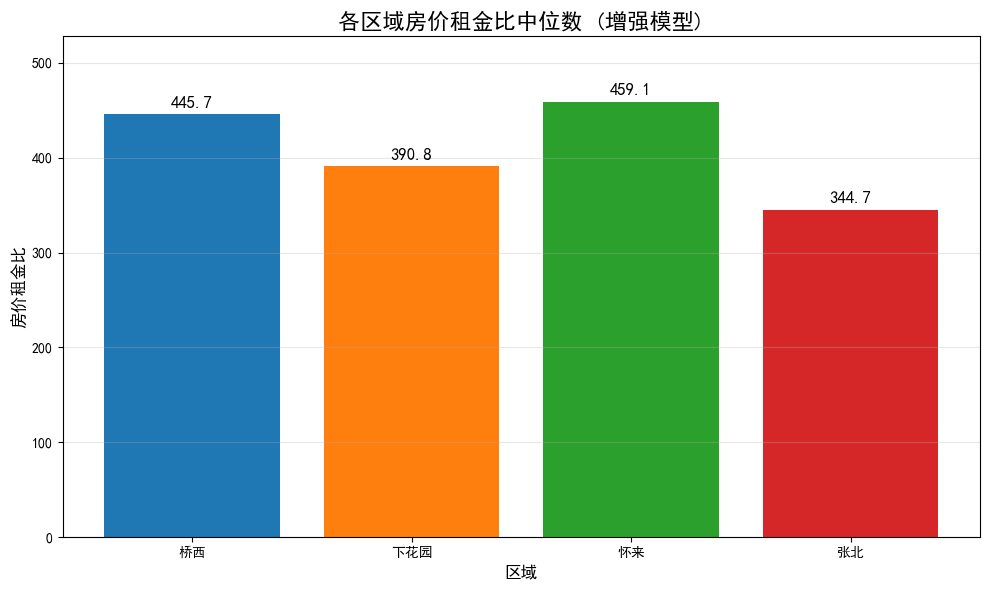

各区域租售比中位数 (增强模型):
桥西: 445.72
下花园: 390.79
怀来: 459.12
张北: 344.73


In [14]:
# 创建增强特征函数 - 以怀来为基准组
def create_enhanced_features(df):
    enhanced_df = df[['面积', '桥西', '下花园', '张北']].copy()
    enhanced_df['面积平方'] = enhanced_df['面积'] ** 2
    # 只创建三个地区的交互项
    enhanced_df['面积_桥西'] = enhanced_df['面积'] * enhanced_df['桥西']
    enhanced_df['面积_下花园'] = enhanced_df['面积'] * enhanced_df['下花园']
    enhanced_df['面积_张北'] = enhanced_df['面积'] * enhanced_df['张北']
    return enhanced_df

# 创建增强特征
X_price_enhanced = create_enhanced_features(esf_df)
X_rent_enhanced = create_enhanced_features(zu_df)

# 训练增强模型
model_price_enhanced = LinearRegression().fit(X_price_enhanced, y_price)
model_rent_enhanced = LinearRegression().fit(X_rent_enhanced, y_rent)

# 为所有数据创建增强特征
all_data_enhanced = create_enhanced_features(all_data)

# 使用增强模型预测
all_data['predicted_price_enhanced'] = model_price_enhanced.predict(all_data_enhanced)
all_data['predicted_rent_enhanced'] = model_rent_enhanced.predict(all_data_enhanced)
all_data['price_to_rent_ratio_enhanced'] = all_data['predicted_price_enhanced'] / all_data['predicted_rent_enhanced']

# 计算中位数
median_ratios_enhanced = all_data.groupby('region')['price_to_rent_ratio_enhanced'].median()
median_ratios_enhanced = median_ratios_enhanced.reindex(desired_order)

# 绘制条形图
plt.figure(figsize=(10, 6))
bars = plt.bar(median_ratios_enhanced.index, median_ratios_enhanced.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for bar, value in zip(bars, median_ratios_enhanced.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', 
             ha='center', va='bottom', fontsize=12)

plt.title('各区域房价租金比中位数 (增强模型)', fontsize=16, fontweight='bold')
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价租金比', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(median_ratios_enhanced.values) * 1.15)
plt.tight_layout()
plt.show()

# 输出结果
print("各区域房价租金比中位数 (增强模型):")
for region, ratio in median_ratios_enhanced.items():
    print(f"{region}: {ratio:.2f}")

In [25]:
# 计算R²分数
r2_price_basic = model_price.score(X_price, y_price)
r2_price_enhanced = model_price_enhanced.score(X_price_enhanced, y_price)
r2_rent_basic = model_rent.score(X_rent, y_rent)
r2_rent_enhanced = model_rent_enhanced.score(X_rent_enhanced, y_rent)

# 输出模型比较结果
print("=== 模型性能比较 ===")
print(f"价格模型 R²:")
print(f"  基础模型: {r2_price_basic:.4f}")
print(f"  增强模型: {r2_price_enhanced:.4f}")
print(f"  改进: {r2_price_enhanced - r2_price_basic:.4f}")

print(f"\n租金模型 R²:")
print(f"  基础模型: {r2_rent_basic:.4f}")
print(f"  增强模型: {r2_rent_enhanced:.4f}")
print(f"  改进: {r2_rent_enhanced - r2_rent_basic:.4f}")

# 直接计算的房价租金比数据
direct_ratios = {
    '桥西': 434.85,
    '下花园': 285.55,
    '怀来': 415.45,
    '张北': 361.50
}

# 比较房价租金比结果
print("\n=== 房价租金比比较 ===")
print("区域\t直接计算\t基础模型\t增强模型")
for region in desired_order:
    direct_ratio = direct_ratios[region]
    basic_ratio = median_ratios[region]
    enhanced_ratio = median_ratios_enhanced[region]
    print(f"{region}\t{direct_ratio:.2f}\t{basic_ratio:.2f}\t{enhanced_ratio:.2f}")


=== 模型性能比较 ===
价格模型 R²:
  基础模型: 0.2134
  增强模型: 0.2309
  改进: 0.0175

租金模型 R²:
  基础模型: 0.1414
  增强模型: 0.3025
  改进: 0.1611

=== 房价租金比比较 ===
区域	直接计算	基础模型	增强模型
桥西	434.85	424.92	445.72
下花园	285.55	307.49	390.79
怀来	415.45	429.71	459.12
张北	361.50	339.94	344.73
